In [1]:
%load_ext autoreload
%autoreload 2

import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import rankdata

from htc_projects.sepsis_icu.settings_sepsis_icu import settings_sepsis_icu
from htc_projects.sepsis_icu.utils import save_figure

In [2]:
plt.rcParams["font.family"] = settings_sepsis_icu.font_family
plt.rcParams["font.sans-serif"] = settings_sepsis_icu.font
plt.rcParams["font.size"] = settings_sepsis_icu.font_size
plt.rcParams["xtick.labelsize"] = settings_sepsis_icu.font_size
plt.rcParams["ytick.labelsize"] = settings_sepsis_icu.font_size

In [3]:
def timeline_plot(target: str = "sepsis", metric: str = "AUROC", restricted: bool = False, annotate_rank: bool = False):
    if restricted:
        name_str = "_restricted"
    else:
        name_str = ""

    metadata_ranking_path = settings_sepsis_icu.results_dir / f"feature_importance_rankings{name_str}.json"
    with metadata_ranking_path.open("r") as f:
        metadata_ranking_dict = json.load(f)

    fig, ax = plt.subplots(
        1, 2, figsize=(settings_sepsis_icu.page_width_inch, 3), sharey="row", constrained_layout=True
    )

    subplot_titles = ["available within 1 hour", "available within 10 hours"]
    for j, timedelta in enumerate([1, 10]):
        df_sub = pd.read_pickle(
            settings_sepsis_icu.results_dir / f"{target}_metadata_adding_rf_importances_{timedelta}hrs{name_str}.pkl"
        )
        df_sub_long = df_sub.copy().explode(["AUROC", "AUPRC", "minimum_ppv", "brier_binary"])
        df_agg = pd.read_pickle(
            settings_sepsis_icu.results_dir
            / f"{target}_metadata_adding_rf_importances_{timedelta}hrs{name_str}_agg.pkl"
        )
        max_n_features = df_sub_long["n_features"].max()
        df_sub_long = df_sub_long.query("n_features <= 3 or n_features == @max_n_features")
        df_agg = df_agg.query("n_features <= 3 or n_features == @max_n_features")
        display(df_agg)

        sns.boxplot(
            df_sub_long,
            x="n_features",
            order=sorted(df_sub_long.n_features.unique()),
            y=metric,
            hue="model",
            palette=settings_sepsis_icu.model_colors,
            showmeans=True,
            meanline=True,
            meanprops=dict(linestyle="dotted", linewidth=0.7, color="black"),
            showfliers=False,
            ax=ax[j],
        )

        y_max = 1.01 if target == "sepsis" else 0.96
        if annotate_rank:
            y_diff = 0.02 if target == "sepsis" else 0.025
            ax[j].text(
                0,
                y_max - y_diff,
                "rank 1:",
                color=settings_sepsis_icu.model_colors["HSI + clinical data"],
                ha="center",
                va="center",
            )
            for n, n_features in enumerate([1, 2, 3, df_sub["n_features"].max()]):
                df_sub_n = df_sub[df_sub["n_features"] == n_features]
                rankings = rankdata(
                    1
                    - np.stack([
                        df_sub_n.query("model == 'HSI + clinical data'")["AUROC"].iloc[0],
                        df_sub_n.query("model == 'clinical data'")["AUROC"].iloc[0],
                    ]),
                    axis=0,
                    method="min",
                )
                counts = np.unique(rankings[0, :], return_counts=True)[1]
                ax[j].text(
                    n + 1,
                    y_max - y_diff,
                    f"{counts[0] / counts.sum() * 100:.0f} %",
                    color=settings_sepsis_icu.model_colors["HSI + clinical data"],
                    ha="center",
                    va="center",
                )

        for patch in ax[j].patches:
            fc = patch.get_facecolor()
            patch.set_facecolor(mpl.colors.to_rgba(fc, 0.7))
            handles, labels = ax[j].get_legend_handles_labels()

        ax[j].set_ylim(None, y_max)
        ax[j].grid(True, linestyle="dotted")
        ax[j].set_ylabel(metric, fontsize=settings_sepsis_icu.font_size)
        ax[j].set_xlabel("input data", fontsize=settings_sepsis_icu.font_size)
        ax[j].set_title(subplot_titles[j])
        ax[j].get_legend().remove()

        clinical_data_order = metadata_ranking_dict[target][str(timedelta)]
        clinical_data_order = [
            (
                f"+{n.replace('_', ' ')}"
                if n not in settings_sepsis_icu.metadata_paper_renaming.keys()
                else f"+{settings_sepsis_icu.metadata_paper_renaming[n]}"
            )
            for n in clinical_data_order
        ]
        x_ticklabels = (
            ["HSI palm"]
            + [
                clinical_data_order[i - 1].replace(" ", "\n") + f" ({i})"
                for i in sorted(df_sub_long.n_features.unique())[1:-1]
            ]
            + [f"+ all others ({len(clinical_data_order)})"]
        )
        ax[j].set_xticklabels(x_ticklabels, rotation=90)
        ax[j].tick_params(axis="x", which="major", pad=30)

    if target == "sepsis":
        labels = [l.replace("HSI", "HSI palm") for l in labels]
        legend = fig.legend(
            handles=handles,
            labels=labels,
            loc="lower center",
            bbox_to_anchor=(0.5, 1.22),
            ncol=3,
        )

    savepath = (
        settings_sepsis_icu.results_dir / "paper_figures" / f"Clinical_data_timeline_{target}_{metric}{name_str}.pdf"
    )
    savepath.parent.mkdir(parents=True, exist_ok=True)
    save_figure(savepath, fig, dpi=300, bbox_inches="tight")

,model,n_features,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_ppv,std_ppv,percentile_025_ppv,percentile_975_ppv,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary,target,timedelta
0,HSI,0,0.802,0.021818,0.758951,0.842993,0.583152,0.045941,0.500032,0.675963,0.292906,0.021845,0.254005,0.336384,0.196912,0.005132,0.186978,0.206588,sepsis,1
1,HSI + clinical data,1,0.866264,0.018325,0.827822,0.899601,0.743899,0.038580,0.661625,0.814075,0.292906,0.021845,0.254005,0.336384,0.180408,0.004357,0.172275,0.189409,sepsis,1
2,HSI + clinical data,2,0.87277,0.017619,0.835617,0.904196,0.740508,0.039490,0.660035,0.812766,0.292906,0.021845,0.254005,0.336384,0.176582,0.004282,0.168505,0.185186,sepsis,1
3,HSI + clinical data,3,0.88537,0.017181,0.849923,0.916117,0.754692,0.039037,0.674515,0.828446,0.292906,0.021845,0.254005,0.336384,0.170901,0.004450,0.161971,0.179988,sepsis,1
33,HSI + clinical data,33,0.896423,0.015100,0.867498,0.924327,0.769608,0.037883,0.692369,0.837489,0.292906,0.021845,0.254005,0.336384,0.168734,0.004497,0.159839,0.178320,sepsis,1
34,clinical data,1,0.75879,0.027673,0.701412,0.811379,0.583666,0.046177,0.492967,0.670697,0.292906,0.021845,0.254005,0.336384,0.182034,0.006146,0.169893,0.194702,sepsis,1
35,clinical data,2,0.81323,0.022671,0.765891,0.852923,0.62278,0.046107,0.530389,0.707284,0.292906,0.021845,0.254005,0.336384,0.173442,0.006136,0.161306,0.185259,sepsis,1
36,clinical data,3,0.859652,0.017350,0.824818,0.889417,0.675078,0.043709,0.588072,0.753102,0.292906,0.021845,0.254005,0.336384,0.164215,0.005771,0.153644,0.175825,sepsis,1
66,clinical data,33,0.90022,0.015014,0.869819,0.926858,0.784156,0.036794,0.706700,0.847019,0.292906,0.021845,0.254005,0.336384,0.157718,0.004610,0.149302,0.167262,sepsis,1


[WARNING][py.warnings] /tmp/ipykernel_4028157/89237747.py:105: UserWarning: set_ticklabels() should only warnings.py:110
be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.                                   
  ax.set_xticklabels(x_ticklabels, rotation=90)                                                                         
                                                                                                                        

,model,n_features,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_ppv,std_ppv,percentile_025_ppv,percentile_975_ppv,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary,target,timedelta
0,HSI,0,0.802,0.021818,0.758951,0.842993,0.583152,0.045941,0.500032,0.675963,0.292906,0.021845,0.254005,0.336384,0.196912,0.005132,0.186978,0.206588,sepsis,10
1,HSI + clinical data,1,0.905949,0.014342,0.876718,0.931618,0.782287,0.038188,0.700204,0.848165,0.292906,0.021845,0.254005,0.336384,0.167372,0.004725,0.158356,0.176765,sepsis,10
2,HSI + clinical data,2,0.933636,0.012565,0.906234,0.954803,0.856784,0.030199,0.785750,0.906972,0.292906,0.021845,0.254005,0.336384,0.152807,0.004156,0.145020,0.160907,sepsis,10
3,HSI + clinical data,3,0.943831,0.011529,0.918385,0.963949,0.875155,0.027989,0.811292,0.921483,0.292906,0.021845,0.254005,0.336384,0.148083,0.004090,0.140552,0.156886,sepsis,10
45,HSI + clinical data,45,0.938943,0.011081,0.915723,0.958690,0.852996,0.030189,0.786608,0.904530,0.292906,0.021845,0.254005,0.336384,0.153354,0.004166,0.145196,0.161644,sepsis,10
46,clinical data,1,0.773939,0.024024,0.728665,0.823164,0.57188,0.045277,0.483333,0.661150,0.292906,0.021845,0.254005,0.336384,0.18429,0.007334,0.170181,0.198752,sepsis,10
47,clinical data,2,0.909025,0.015606,0.876795,0.936339,0.807169,0.037026,0.726845,0.868310,0.292906,0.021845,0.254005,0.336384,0.141087,0.005586,0.131248,0.152012,sepsis,10
48,clinical data,3,0.920906,0.013664,0.892266,0.944968,0.819511,0.033946,0.750070,0.879186,0.292906,0.021845,0.254005,0.336384,0.138761,0.005157,0.129648,0.149280,sepsis,10
90,clinical data,45,0.952307,0.009659,0.931107,0.968931,0.890827,0.024756,0.835299,0.931079,0.292906,0.021845,0.254005,0.336384,0.141879,0.003916,0.135111,0.149875,sepsis,10


[WARNING][htc] The width of the figure Clinical_data_timeline_sepsis_AUROC.pdf is 18.711 cm instead of      utils.py:208
18.415 cm (-3.711 missing)                                                                                              

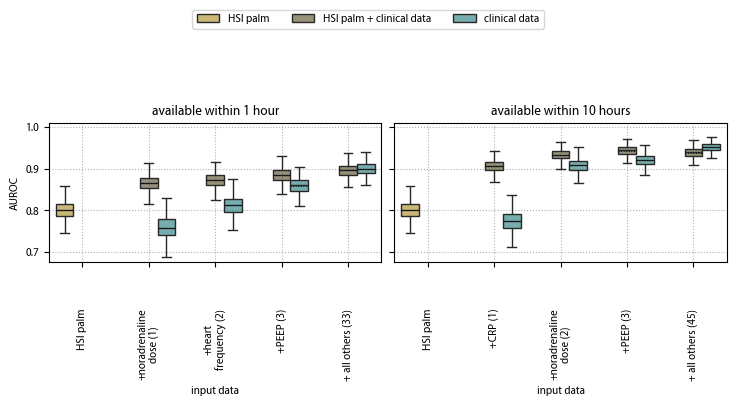

In [4]:
timeline_plot()

,model,n_features,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_ppv,std_ppv,percentile_025_ppv,percentile_975_ppv,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary,target,timedelta
0,HSI,0,0.72148,0.036451,0.651738,0.789108,0.338303,0.055016,0.242460,0.459289,0.140787,0.015998,0.109731,0.173913,0.201586,0.004178,0.193222,0.210024,survival,1
1,HSI + clinical data,1,0.753261,0.034144,0.685630,0.816789,0.477548,0.058448,0.350583,0.580220,0.140787,0.015998,0.109731,0.173913,0.197866,0.003347,0.191484,0.204563,survival,1
2,HSI + clinical data,2,0.763579,0.033174,0.692743,0.822673,0.498128,0.056551,0.380832,0.597246,0.140787,0.015998,0.109731,0.173913,0.202939,0.003153,0.196777,0.209016,survival,1
3,HSI + clinical data,3,0.802166,0.029125,0.741217,0.854496,0.468469,0.062510,0.343129,0.584960,0.140787,0.015998,0.109731,0.173913,0.195548,0.003615,0.188701,0.202371,survival,1
33,HSI + clinical data,33,0.824702,0.028841,0.764594,0.876113,0.504274,0.062294,0.374087,0.622203,0.140787,0.015998,0.109731,0.173913,0.183836,0.003875,0.176354,0.191557,survival,1
34,clinical data,1,0.641362,0.037075,0.564253,0.710006,0.375649,0.052848,0.263242,0.476477,0.140787,0.015998,0.109731,0.173913,0.149774,0.006138,0.138228,0.162323,survival,1
35,clinical data,2,0.707967,0.036694,0.628390,0.773832,0.425737,0.055237,0.306693,0.526169,0.140787,0.015998,0.109731,0.173913,0.142215,0.005227,0.132470,0.152565,survival,1
36,clinical data,3,0.75383,0.036739,0.678301,0.822736,0.456148,0.058587,0.332746,0.560948,0.140787,0.015998,0.109731,0.173913,0.138965,0.004982,0.129393,0.149415,survival,1
66,clinical data,33,0.815997,0.028520,0.756706,0.867316,0.461437,0.060637,0.346724,0.584357,0.140787,0.015998,0.109731,0.173913,0.140096,0.004810,0.130674,0.150180,survival,1


,model,n_features,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_ppv,std_ppv,percentile_025_ppv,percentile_975_ppv,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary,target,timedelta
0,HSI,0,0.72148,0.036451,0.651738,0.789108,0.338303,0.055016,0.242460,0.459289,0.140787,0.015998,0.109731,0.173913,0.201586,0.004178,0.193222,0.210024,survival,10
1,HSI + clinical data,1,0.753261,0.034144,0.685630,0.816789,0.477548,0.058448,0.350583,0.580220,0.140787,0.015998,0.109731,0.173913,0.197866,0.003347,0.191484,0.204563,survival,10
2,HSI + clinical data,2,0.785904,0.030102,0.724688,0.841475,0.467589,0.061691,0.340241,0.584778,0.140787,0.015998,0.109731,0.173913,0.19767,0.003522,0.190954,0.204337,survival,10
3,HSI + clinical data,3,0.789099,0.031151,0.726174,0.845497,0.460201,0.061621,0.335704,0.581768,0.140787,0.015998,0.109731,0.173913,0.195942,0.003661,0.188940,0.202943,survival,10
45,HSI + clinical data,45,0.829997,0.026798,0.776959,0.876935,0.523562,0.059834,0.403890,0.636717,0.140787,0.015998,0.109731,0.173913,0.181484,0.003853,0.174105,0.189032,survival,10
46,clinical data,1,0.641362,0.037075,0.564253,0.710006,0.375649,0.052848,0.263242,0.476477,0.140787,0.015998,0.109731,0.173913,0.149774,0.006138,0.138228,0.162323,survival,10
47,clinical data,2,0.743359,0.034850,0.670475,0.803933,0.442915,0.055870,0.329647,0.552499,0.140787,0.015998,0.109731,0.173913,0.140237,0.005223,0.130164,0.150726,survival,10
48,clinical data,3,0.761446,0.034208,0.689435,0.823892,0.420571,0.060351,0.298355,0.534509,0.140787,0.015998,0.109731,0.173913,0.140473,0.005023,0.130722,0.150815,survival,10
90,clinical data,45,0.811022,0.028457,0.749686,0.864283,0.437,0.060870,0.319582,0.557243,0.140787,0.015998,0.109731,0.173913,0.141998,0.004834,0.132422,0.151955,survival,10


[WARNING][htc] The width of the figure Clinical_data_timeline_survival_AUROC.pdf is 18.711 cm instead of    utils.py:208
18.415 cm (-3.711 missing)                                                                                              

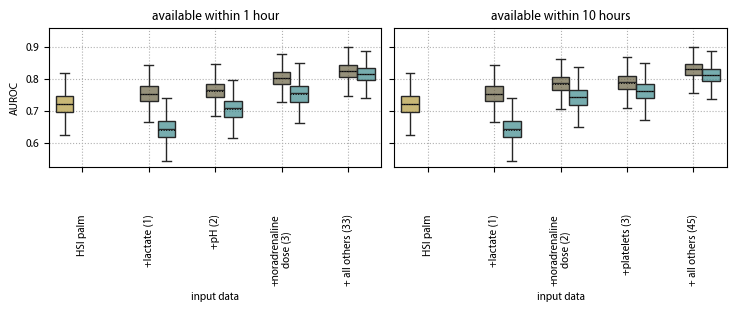

In [5]:
timeline_plot("survival")